In [1]:
import numpy as np
import pandas as pd
import os
import re
import sys
sys.path.append('../scripts')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from data_featurization import (load_data, load_cif_structure, load_ordered_cif_structure, remove_charges, simplify_structure, 
remove_li_from_mixed_sites, construct_megnet_graph, get_megnet_feature, get_megnet_composition_feature, find_duplicate_structures, 
get_space_group, extract_features_until_convergence)

from pymatgen.core.periodic_table import Element
from pymatgen.core.structure import Structure, Composition, PeriodicSite, Species
from pymatgen.analysis.structure_matcher import StructureMatcher

from tqdm.auto import tqdm as tqdm_pandas
from megnet.data.crystal import CrystalGraph, CrystalGraphDisordered
from megnet.data.graph import GaussianDistance
from megnet.models import MEGNetModel
from maml.describers import MEGNetSite, MEGNetStructure

from tqdm.auto import tqdm as tqdm_pandas
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
tqdm_pandas.pandas()

### Define paths for relevant directories

In [3]:
icsd_li_cifs_path = r"..\data\icsd_li_cifs"
ordered_cifs_path = r"..\data\ordered_cifs_wo_li"
labelled_conductivity_database_path = r"..\data\ionic_conductivity_database.csv"
pretrained_model_path = r"..\megnet\mvl_models\mp-2019.4.1\formation_energy.hdf5"
describer_model_path = r"..\pretrained_models\mp-2019_4_1_formation_energy_disordered"

In [3]:
labelled_conductivity_database = load_data(labelled_conductivity_database_path)
labelled_conductivity_database['conductivity_siemens_per_cm'] = labelled_conductivity_database['conductivity_siemens_per_cm'].astype(float)
labelled_conductivity_database['log10conductivity'] = np.log10(labelled_conductivity_database['conductivity_siemens_per_cm'])
labelled_conductivity_database['is_superionic'] = (labelled_conductivity_database['log10conductivity'] > -4).astype(int)
labelled_conductivity_database = labelled_conductivity_database.reset_index(drop=True)

### Load Pymatgen structures for ICSD entries and ordered versions of materials

In [28]:
labelled_conductivity_database['structure'] = labelled_conductivity_database['icsd_collectioncode'].progress_apply(load_cif_structure, cif_dir=icsd_li_cifs_path)   
labelled_conductivity_database['ordered_structure_wo_Li'] = labelled_conductivity_database['icsd_collectioncode'].progress_apply(load_ordered_cif_structure, cif_dir=ordered_cifs_path)

  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/571 [00:00<?, ?it/s]

No cif found for ICSD entry 22436
No cif found for ICSD entry 30301
No cif found for ICSD entry 30303
No cif found for ICSD entry 30304
No cif found for ICSD entry 32326
No cif found for ICSD entry 34359
No cif found for ICSD entry 36942
No cif found for ICSD entry 36943
No cif found for ICSD entry 38290
No cif found for ICSD entry 51332
No cif found for ICSD entry 65051
No cif found for ICSD entry 111751
No cif found for ICSD entry 111756
No cif found for ICSD entry 121998
No cif found for ICSD entry 143976
No cif found for ICSD entry 143977
No cif found for ICSD entry 163300
No cif found for ICSD entry 168141
No cif found for ICSD entry 168144
No cif found for ICSD entry 170956
No cif found for ICSD entry 196465
No cif found for ICSD entry 241475
No cif found for ICSD entry 247057
No cif found for ICSD entry 264526
No cif found for ICSD entry 403573
No cif found for ICSD entry 403574
No cif found for ICSD entry 412011
No cif found for ICSD entry 430574
No cif found for ICSD entry 430

### Remove duplicate structures while keeping median conductivity values

In [30]:
duplicates = find_duplicate_structures(labelled_conductivity_database)
final_entries = []
for struc, indices in duplicates.items():
    if len(indices) == 1:
        final_entries.append(indices[0])
    else:
        conductivity_values = labelled_conductivity_database.iloc[indices]['conductivity_siemens_per_cm']
                
        if len(indices) == 2:
            kept_index = indices[conductivity_values.argmax()]
        else:
            median_index = (len(conductivity_values) - 1) // 2
            sorted_indices = sorted(indices, key=lambda x: conductivity_values[x])
            kept_index = sorted_indices[median_index]
        final_entries.append(kept_index)

labelled_conductivity_database_wo_duplicates = labelled_conductivity_database.iloc[final_entries]
labelled_conductivity_database_wo_duplicates = labelled_conductivity_database_wo_duplicates.reset_index(drop=True)
csv_columns = [col for col in labelled_conductivity_database_wo_duplicates.columns if col not in ["structure", "ordered_structure_wo_Li"]]
labelled_conductivity_database_wo_duplicates[csv_columns].to_csv(r'..\data\ionic_conductivity_database_wo_duplicates.csv', index=False)

### Create simplified versions of structures

In [11]:
labelled_conductivity_database_wo_duplicates = load_data(r'..\data\ionic_conductivity_database_wo_duplicates.csv')
labelled_conductivity_database_wo_duplicates['structure'] = labelled_conductivity_database_wo_duplicates['icsd_collectioncode'].progress_apply(load_cif_structure, cif_dir=icsd_li_cifs_path)   
labelled_conductivity_database_wo_duplicates['structure_simplified'] = labelled_conductivity_database_wo_duplicates['structure'].progress_apply(simplify_structure)
labelled_conductivity_database_wo_duplicates['structure_wo_Li'] = labelled_conductivity_database_wo_duplicates['structure'].progress_apply(remove_li_from_mixed_sites)
labelled_conductivity_database_wo_duplicates['structure_simplified_wo_Li'] = labelled_conductivity_database_wo_duplicates['structure_simplified'].progress_apply(remove_li_from_mixed_sites)

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

### Create graph-based features for different structure types

In [17]:
# Initialize CrystalGraphDisordered object for creating graphs from structures
cg_disordered = CrystalGraphDisordered(bond_converter=GaussianDistance(np.linspace(0, 6, 100), 0.5), cutoff=5)

# Load pretrained MEGNetModel from file
pretrained_model = MEGNetModel.from_file(pretrained_model_path)

# Extract elemental embeddings from the pretrained model weights
weights = pretrained_model.get_weights()
elemental_embeddings = weights[0]

# Define columns containing different types of structures
structure_columns = ['structure', 'structure_wo_Li', 'structure_simplified',
                     'structure_simplified_wo_Li', 'ordered_structure_wo_Li']

# Initialize list to store feature column names
feature_columns = []

# Iterate over each type of structure
for structure_type in structure_columns:
    # Define column name for the corresponding MEGNet graph representation
    graph_column_name = "megnet_graph_" + structure_type
    
    # Apply construct_megnet_graph function to create MEGNet graph representations
    # and store the result in a new column in the dataframe
    labelled_conductivity_database_wo_duplicates[graph_column_name] = labelled_conductivity_database_wo_duplicates[structure_type].progress_apply(construct_megnet_graph, graph_converter=cg_disordered, embeddings=elemental_embeddings)

    # Iterate over different levels of MEGNet site describers
    for i in range(0, 4):
        if i == 0:
            # Define column name for the corresponding MEGNet site feature
            feature_column_name = structure_type + f"_megnet_site_feature_level_{i}_2019_4_1_formation_energy"
            feature_columns.append(feature_column_name)
            labelled_conductivity_database_wo_duplicates[feature_column_name] = labelled_conductivity_database_wo_duplicates[graph_column_name].progress_apply(get_megnet_composition_feature)
        else:
            # Initialize MEGNetSite describer for the current level
            megnet_site_describer = MEGNetSite(level=i, name=describer_model_path)
            
            # Define column name for the corresponding MEGNet site feature
            feature_column_name = structure_type + f"_megnet_site_feature_level_{i}_2019_4_1_formation_energy"
            feature_columns.append(feature_column_name)
            
            # Apply get_megnet_feature function to extract MEGNet site features
            # and store the result in a new column in the dataframe
            labelled_conductivity_database_wo_duplicates[feature_column_name] = labelled_conductivity_database_wo_duplicates[graph_column_name].progress_apply(get_megnet_feature, describer=megnet_site_describer)

    # Initialize MEGNetStructure describer for the final level
    megnet_structure_describer = MEGNetStructure(mode='final', name=describer_model_path)

    # Define column name for the corresponding MEGNet structure feature
    feature_column_name = structure_type + f"_megnet_structure_feature_level_final_2019_4_1_formation_energy"
    feature_columns.append(feature_column_name)
    
    # Apply get_megnet_feature function to extract MEGNet structure features
    # and store the result in a new column in the dataframe
    labelled_conductivity_database_wo_duplicates[feature_column_name] = labelled_conductivity_database_wo_duplicates[graph_column_name].progress_apply(get_megnet_feature, describer=megnet_structure_describer)

# Define columns for the final feature dataframe
feature_df_columns = feature_columns + ['compound', 'icsd_collectioncode', 'conductivity_siemens_per_cm',
                                        'lowest_extrapolation_temperature_K', 'log10conductivity',
                                        'is_superionic']

# Create a dataframe containing only the feature columns
feature_df = labelled_conductivity_database_wo_duplicates[feature_df_columns]
feature_df.to_pickle('..\data\graph_based_features_11022023_wo_duplicates.pkl')

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/548 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


### Create atomistic features for different structures

In [4]:
labelled_conductivity_database_wo_duplicates = load_data(r'..\data\ionic_conductivity_database_11022023_wo_duplicates.csv')
labelled_conductivity_database_wo_duplicates['structure'] = labelled_conductivity_database_wo_duplicates['icsd_collectioncode'].progress_apply(load_cif_structure, cif_dir=icsd_li_cifs_path)

  0%|          | 0/548 [00:00<?, ?it/s]

In [6]:
single_dis = []
for index, row in labelled_conductivity_database_wo_duplicates.iterrows():
    icsd_code = row['icsd_collectioncode']
    struc = row['structure']
    disordered_sites = [site for site in struc if not site.is_ordered]
    if len(disordered_sites) == 1:
        single_dis.append(icsd_code)

In [7]:
single_dis

[16800,
 180629,
 180630,
 180631,
 180632,
 180633,
 180634,
 180635,
 188649,
 188650,
 188651,
 188652,
 190825,
 190826,
 190827,
 190830,
 254044]

Please note that the code shown below was executed in parallel on an HPC

In [ ]:
atomistic_data = []

# Loop through each row in the original DataFrame
for idx, row in tqdm(labelled_conductivity_database_wo_duplicates.iterrows(), total=len(labelled_conductivity_database_wo_duplicates )):
    icsd_code = row['icsd_collectioncode']
    if icsd_code == 38290 or icsd_code == 11042:
        print(f'Obtaining atomistic features for icsd {icsd_code}')
        structure = row['structure']
        
        # Extract features using the extract_features_until_convergence function
        result = extract_features_until_convergence(structure)
        # Append the ICSD code and the results to the data list
        if result is not None:
            atomistic_data.append([icsd_code] + list(result))
        else:
            # If no result, append None values for each feature
            atomistic_data.append([icsd_code, None, None, None, None, None])

# Convert the list to a DataFrame
atomistic_feature_df = pd.DataFrame(atomistic_data, columns=[
    'icsd_collectioncode', 
    'avg_min_li_li_distance', 
    'avg_min_li_anion_distance', 
    'avg_num_li_li_bonds', 
    'avg_ionicity', 
    'avg_anion_coordination'
])

# Save the new DataFrame
#atomistic_feature_df.to_pickle("../data/atomistic_features_new.pkl")
#atomistic_feature_df.to_csv("../data/atomistic_features_new.csv")

### Create summary figure for database

In [4]:
labelled_conductivity_database_wo_duplicates = pd.read_csv('..\data\ionic_conductivity_database_11022023_wo_duplicates.csv')
labelled_conductivity_database_wo_duplicates['space_group'] = labelled_conductivity_database_wo_duplicates['icsd_collectioncode'].progress_apply(get_space_group, cif_dir=icsd_li_cifs_path)
labelled_conductivity_database_wo_duplicates['structure'] = labelled_conductivity_database_wo_duplicates['icsd_collectioncode'].progress_apply(load_cif_structure, cif_dir=icsd_li_cifs_path)
labelled_conductivity_database_wo_duplicates['ordered'] = [struc.is_ordered for struc in labelled_conductivity_database_wo_duplicates['structure'].to_list()]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

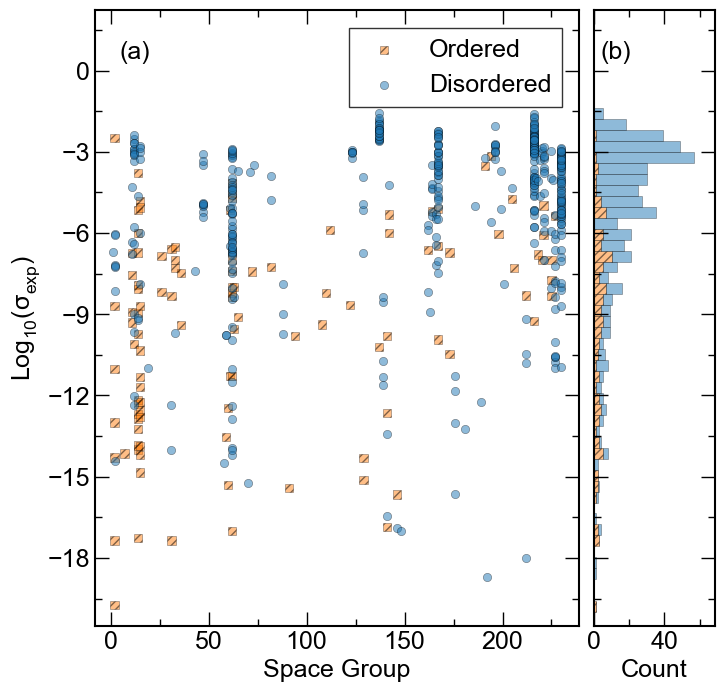

In [17]:
labelled_conductivity_database_wo_duplicates_sorted = labelled_conductivity_database_wo_duplicates.sort_values(by='space_group')

# Split the dataframe based on 'ordered' column
ordered_true = labelled_conductivity_database_wo_duplicates_sorted[labelled_conductivity_database_wo_duplicates_sorted['ordered'] == True]
ordered_false = labelled_conductivity_database_wo_duplicates_sorted[labelled_conductivity_database_wo_duplicates_sorted['ordered'] == False]

color_disordered = "tab:blue"
color_ordered = "tab:orange"

# Plot settings
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1.5

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(1, 2, width_ratios=[4, 1], figure=fig, wspace=0.05)

# Define major and minor ticks
major_sg_xticks = [0, 50, 100, 150, 200]
minor_sg_xticks = [25, 75, 125, 175, 225]
major_cond_yticks = [-18, -15, -12, -9, -6, -3, 0]
minor_cond_yticks = [-19.5, -16.5, -13.5, -10.5, -7.5, -4.5, -1.5, 1.5]
major_condcount_xticks = [0, 40]
minor_condcount_xticks = [20, 60]

# Main scatter plot
ax_main = fig.add_subplot(gs[0, 0])
ax_main.text(0.05, 0.95, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax_main.transAxes)
ax_main.scatter(ordered_true['space_group'], ordered_true['log10conductivity'], alpha=0.5, color=color_ordered, edgecolors='k', marker='s', hatch='////', linewidth=0.4, label='Ordered')
ax_main.scatter(ordered_false['space_group'], ordered_false['log10conductivity'], alpha=0.5, color=color_disordered, edgecolors='k', linewidth=0.4, marker='o', label='Disordered')

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

ax_main.set_ylabel(r'Log$_{10}(\sigma_{exp})$', fontsize=18)
ax_main.set_xlabel('Space Group', fontsize=18)
ax_main.set_xticks(major_sg_xticks)
ax_main.set_xticks(minor_sg_xticks, minor=True)
ax_main.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)  # Set tick parameters for major ticks
ax_main.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)  # Set tick parameters for minor ticks
ax_main.set_xlim([-8, 239])
ax_main.set_ylim([-20.5, 2.25])
ax_main.set_xticks(major_sg_xticks)
ax_main.set_xticks(minor_sg_xticks, minor=True)
ax_main.set_yticks(major_cond_yticks)
ax_main.set_yticks(minor_cond_yticks, minor=True)

# Add legend to the main plot
ax_main.legend(loc='upper right', bbox_to_anchor=(0.99, 0.99), fontsize=18, frameon=True, fancybox=False, edgecolor='k')

ax_right = fig.add_subplot(gs[0, 1])
bins = 55

# First histogram (ordered_true) without hatching
counts_ordered_true, bins_true, _ = ax_right.hist(ordered_true['log10conductivity'], 
              orientation='horizontal', bins=bins, 
              color=color_ordered, 
              edgecolor='k', linewidth=0.4, alpha=0.5, label='Ordered', hatch='////', 
                                                  range=(-20, 2.25))

# Second histogram (ordered_false) with hatching, stacked on top of ordered_true
ax_right.hist(ordered_false['log10conductivity'], 
              orientation='horizontal', bins=bins, 
              color=color_disordered, 
              edgecolor='k', linewidth=0.4, alpha=0.5, label='Disordered', 
              bottom=counts_ordered_true, range=(-20, 2.25))

ax_right.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax_right.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax_right.set_xlabel('Count', fontsize=18)
ax_right.set_ylabel('')
ax_right.set_yticklabels([])
ax_right.set_ylim([-20.5, 2.25])
ax_right.set_xlim([0, 68.75])
ax_right.set_yticks(major_cond_yticks)
ax_right.set_yticks(minor_cond_yticks, minor=True)
ax_right.set_xticks(major_condcount_xticks)
ax_right.set_xticks(minor_condcount_xticks, minor=True)
ax_right.text(0.05, 0.95, '(b)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax_right.transAxes)

plt.tight_layout()
plt.savefig('../figures/Figure_1.tif', dpi=600, bbox_inches='tight')
plt.show()